# Coagulation with Charge (Functional + Factory)
This tutorial demonstrates the functional workflow for charged coagulation using the public factory API in `particula.dynamics`. We:
- define a charged particle size distribution,
- compute required transport properties,
- obtain a charged coagulation strategy via `CoagulationFactory`, and
- visualize the resulting coagulation kernel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import particula as par

plt.rcParams["figure.dpi"] = 110

## Define the particle size distribution
Logarithmic grid (1 nm to 10 μm) with unit-density mass bins.

In [2]:
radius_bins = np.logspace(start=-9, stop=-4, num=250)  # m (1 nm to 10 μm)
mass_bins = 4 / 3 * np.pi * radius_bins**3 * 1e3  # kg (ρ = 1000 kg/m³)
n_bins = len(radius_bins)

## Assign particle charges
Negative charges cover the first third; positive charges cover the remaining two thirds.

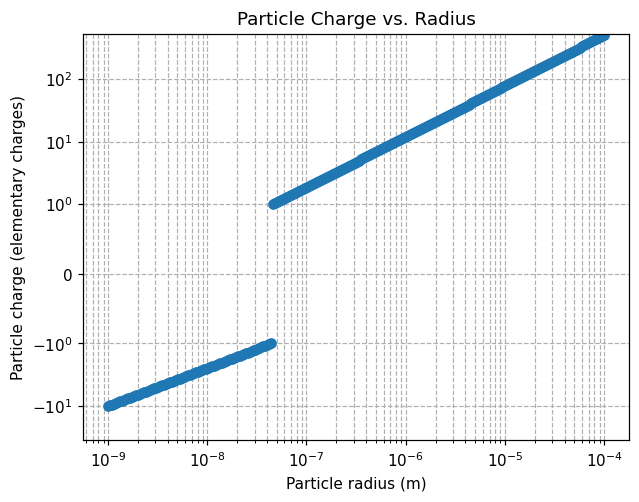

In [3]:
split_index = n_bins // 3
neg_charges = -np.logspace(np.log10(10), np.log10(1), num=split_index)
pos_charges = np.logspace(np.log10(1), np.log10(500), num=n_bins - split_index)
charge_array = np.concatenate((neg_charges, pos_charges))

fig, ax = plt.subplots()
ax.plot(radius_bins, charge_array, marker="o", linestyle="none")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1)
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Particle charge (elementary charges)")
ax.set_title("Particle Charge vs. Radius")
ax.grid(True, which="both", ls="--")
plt.show()

## Supporting properties
Compute Coulomb potential ratio, gas properties, Knudsen numbers, slip correction, friction factor, and helper matrices.

In [4]:
temperature = 298.15  # K

coulomb_potential_ratio: np.ndarray = np.asarray(
    par.particles.get_coulomb_enhancement_ratio(
        radius_bins, charge_array, temperature=temperature
    ),
    dtype=float,
)
dynamic_viscosity = par.gas.get_dynamic_viscosity(temperature=temperature)
mol_free_path = par.gas.get_molecule_mean_free_path(
    temperature=temperature, dynamic_viscosity=dynamic_viscosity
)
knudsen_number = par.particles.get_knudsen_number(
    mean_free_path=mol_free_path, particle_radius=radius_bins
)
slip_correction = par.particles.get_cunningham_slip_correction(
    knudsen_number=knudsen_number
)
friction_factor_value = par.particles.get_friction_factor(
    particle_radius=radius_bins,
    dynamic_viscosity=dynamic_viscosity,
    slip_correction=slip_correction,
)
diffusive_knudsen_values: np.ndarray = np.asarray(
    par.particles.get_diffusive_knudsen_number(
        particle_radius=radius_bins,
        particle_mass=mass_bins,
        friction_factor=friction_factor_value,
        coulomb_potential_ratio=coulomb_potential_ratio,
        temperature=temperature,
    ),
    dtype=float,
)

sum_of_radii = radius_bins[:, np.newaxis] + radius_bins[np.newaxis, :]
reduced_mass = par.util.get_reduced_self_broadcast(mass_bins)
reduced_friction_factor = par.util.get_reduced_self_broadcast(
    friction_factor_value
)

## Get a charged coagulation strategy via factory
Use `CoagulationFactory` with the charged type and a Coulomb kernel strategy. The factory builds the underlying charged coagulation strategy using the provided parameters.

In [5]:
factory = par.dynamics.CoagulationFactory()
kernel_strategy = par.dynamics.CoulombGatti2008KernelStrategy()
coagulation_strategy = factory.get_strategy(
    "charged",
    parameters={
        "distribution_type": "discrete",
        "charged_kernel_strategy": kernel_strategy,
    },
)

dimensionless_kernel = coagulation_strategy.kernel_strategy.dimensionless(
    diffusive_knudsen=diffusive_knudsen_values,
    coulomb_potential_ratio=coulomb_potential_ratio,
)
dimensional_kernel = coagulation_strategy.kernel_strategy.kernel(
    dimensionless_kernel=dimensionless_kernel,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

## Visualize the kernel
Plot the dimensional coagulation kernel returned by the factory-built strategy.

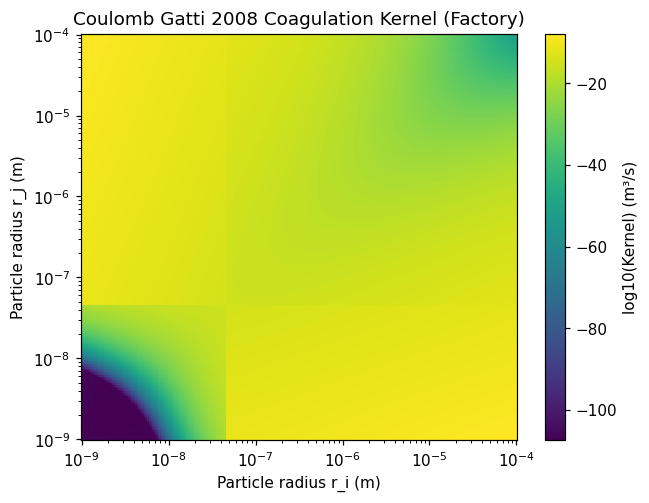

In [6]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(
    radius_bins, radius_bins, np.log10(dimensional_kernel), shading="auto"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius r_i (m)")
ax.set_ylabel("Particle radius r_j (m)")
ax.set_title("Coulomb Gatti 2008 Coagulation Kernel (Factory)")
fig.colorbar(mesh, ax=ax, label="log10(Kernel) (m³/s)")
plt.show()